In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cooler
import pandas as pd
from Bio import SeqIO
import random
from HiCT_Library.hict.api.ContactMatrixFacet import ContactMatrixFacet
from pathlib import Path
from matrix_visualise import MatrixVisualise

## Создание перестроек в fasta

In [4]:
records = {}
with open("data/arab/an_arabiensis_dongola_c.fasta") as handle:
    for record in (SeqIO.parse(handle, "fasta")):
        records[record.id] = record
records

{'X': SeqRecord(seq=Seq('GCTATAATATTCAAATAATTAATATAATGCTAAACTAACGCGCTAATCCTTAGC...AGA'), id='X', name='X', description='X', dbxrefs=[]),
 '2R': SeqRecord(seq=Seq('TTAAAATAAACTAATAAATTTTGCATTAAATTTGCGCGTAACAGTACCTGTTTA...TTA'), id='2R', name='2R', description='2R', dbxrefs=[]),
 '2L': SeqRecord(seq=Seq('CCACAAATCCACCAAACGACCACTAAACGGGTTCTAATCCAAAGTGCCACCAAT...AAA'), id='2L', name='2L', description='2L', dbxrefs=[]),
 '3R': SeqRecord(seq=Seq('AATTCAAAAAAATTATTCTGAATCTAAAAACTGTGTGTTAAATTCAGTAAGAAT...TGG'), id='3R', name='3R', description='3R', dbxrefs=[]),
 '3L': SeqRecord(seq=Seq('CCTTGAAATTTGATGTTGAGTTTTGTTGCCATCTATTATCGTTGTTACGGCCAT...TTT'), id='3L', name='3L', description='3L', dbxrefs=[]),
 'scaffold_8': SeqRecord(seq=Seq('CACGTCGTCCCCAGACTGCCAGTTGTGCGTCGGCGTCCCAGAGACGGCGGAGCA...TTT'), id='scaffold_8', name='scaffold_8', description='scaffold_8', dbxrefs=[]),
 'scaffold_9': SeqRecord(seq=Seq('CCATCTATTATCGTTGTTACGGCCATGTTTCATCAATGAAGCCATCTTGCACTA...TCA'), id='scaffold_9', name='scaff

In [5]:
records_new = {}
records_new['X'] = records['X']
chr2 = records['2L'].seq + 1000*"N" + records['2R'].seq
chr3 = records['3L'].seq + 1000*"N" + records['3R'].seq
records_new['Chr2'] = SeqIO.SeqRecord(chr2,'Chr2','Chr2','Chr2')
records_new['Chr3'] = SeqIO.SeqRecord(chr3,'Chr3','Chr3','Chr3')

In [6]:
for chr in ['X', 'Chr2', 'Chr3']:
    record = records_new[chr]
    print(len(record.seq))

26236154
104202565
96595394


In [18]:
def make_deletion(seq, end):
    length = random.randint(50000, 100000)
    start = end - length
    if start <=0:
        return False
    seq = seq[:start] + seq[end:]

    return seq, start, start

def make_duplication(seq, end):
    length = random.randint(50000, 100000)
    start = end - length
    if start <=0:
        return False
    seq = seq[:end] + seq[start:end] + seq[end:]

    return seq, end, end+length

def make_duplication_reverse(seq, end):
    length = random.randint(50000, 100000)
    start = end - length
    if start <=0:
        return False
    seq = seq[:start] + seq[start:end] + seq[start:end].reverse_complement() + seq[end:]
    return seq, end, end+length

def make_reverse(seq, end):
    length = random.randint(100000, 200000)
    start = end - length
    if start <=0:
        return False
    seq = seq[:start] + seq[start:end].reverse_complement() + seq[end:]

    return seq, start, end

def make_translocation(seq, end, reverse=False):
    length = 5000000#random.randint(20000, 100000)
    start = end - length

    if start <=0:
        return False


    move_length = 1000000#random.randint(1000, 5000)
    moving_start = start + 1000000
    move_seq = seq[moving_start:moving_start+move_length]

    if reverse:
        move_seq = move_seq.reverse_complement()

    move_point = moving_start + move_length + 2000000
    seq = seq[:moving_start] + seq[moving_start+move_length:move_point] + move_seq + seq[move_point:]

    return seq, (moving_start, move_point-move_length), (moving_start, move_point), (move_point-move_length, move_point), start

In [19]:
seqs = {}
with open('data/arab/transitions_medium.csv', mode='w') as output:
    output.write(f'chr,label,start,end\n')
    for chr in ['X', 'Chr2', 'Chr3']:
        record = records_new[chr]
        seq = record.seq
        end = len(seq) - 1
        while True:
            '''
            end -= 1000000
            seq, start, end = make_deletion(seq, end)
            output.write(f'{chr},+-, {start}, {end}\n')
            start, end = end, start
            if end < 1000000:
                break
            end -= 1000000
            seq, start, end = make_duplication(seq, end)
            output.write(f'{chr},-+, {start}, {end}\n')
            start, end = end, start
            if end < 1000000:
                break
            end -= 1000000
            seq, start, end = make_duplication_reverse(seq, end)
            output.write(f'{chr},--, {start}, {end}\n')
            start, end = end, start
            if end < 1000000:
                break
            end -= 1000000
            seq, start, end = make_reverse(seq, end)
            output.write(f'{chr},++, {start}, {end}\n')
            if end < 1000000:
                break
            '''
            seq, plus_minus, minus_plus_1, plus_plus_2, end = make_translocation(seq, end)
            output.write(f'{chr},--,{plus_minus[0]},{plus_minus[1]}\n')
            output.write(f'{chr},++,{minus_plus_1[0]},{minus_plus_1[1]}\n')
            output.write(f'{chr},++,{plus_plus_2[0]},{plus_plus_2[1]}\n')
            if end < 5000000:
                break
            seq, plus_minus, minus_plus_1, minus_plus_2, end = make_translocation(seq, end, True)
            output.write(f'{chr},+-,{plus_minus[0]},{plus_minus[1]}\n')
            output.write(f'{chr},-+, {minus_plus_1[0]},{minus_plus_1[1]}\n')
            output.write(f'{chr},++,{plus_plus_2[0]},{plus_plus_2[1]}\n')
            if end < 5000000:
                break

        seqs[chr] = seq

In [20]:
with open('data/arab/rearrangement_medium.fasta', mode='w') as output:
    for chr in ['X', 'Chr2', 'Chr3']:
        output.write(f'>{chr}\n')
        output.write(str(seqs[chr]))
        output.write('\n')

## Использование перестроек для получения кусков HI-C карты

In [3]:
resolution = 50000
chr = 'X'
c = cooler.Cooler(f'data/arab/ARAB_short_4DN.mcool::/resolutions/{resolution}')
mat_balanced = c.matrix(balance=False).fetch(chr)
mat_balanced+=1

#matrix = MatrixVisualise.log_matrix(MatrixVisualise.calculate_diag_means(mat_balanced, scf_desc,scf_desc),addition=0,remove_zeros=False)
matrix = np.log10(mat_balanced)
trans = pd.read_csv('data/arab/transitions_short.csv')
trans = trans[trans.chr == chr]
trans['start_res'] = trans.start // resolution
trans['end_res'] = trans.end // resolution
trans

,chr,label,start,end,start_res,end_res
0,X,--,24686153,25186153,493,503
1,X,++,24686153,25786153,493,515
2,X,++,25186153,25786153,503,515
3,X,+-,22586153,23086153,451,461
4,X,-+,22586153,23686153,451,473
5,X,++,25186153,25786153,503,515
6,X,--,20486153,20986153,409,419
7,X,++,20486153,21586153,409,431
8,X,++,20986153,21586153,419,431
9,X,+-,18386153,18886153,367,377


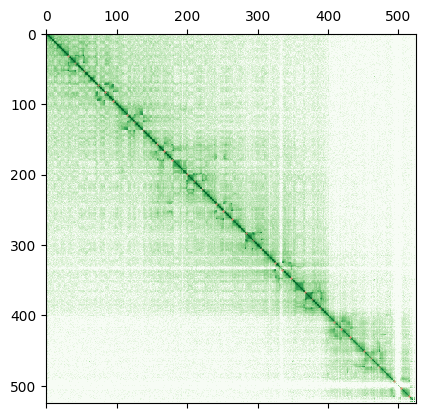

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
#im = ax.matshow(np.log10(calculate_diag_means(mat_balanced)), cmap='Greens')
im = ax.matshow(matrix, cmap='Greens')

plt.scatter(trans.start_res, trans.start_res,s=0.1, c='#E9967A')
plt.scatter(trans.end_res, trans.end_res,s=0.1, c='#E9967A')


plt.savefig('trans.png', dpi=1000)

In [13]:
max_value = np.max(matrix)
min_value = np.min(matrix)
for label, folder in (('+-','plus_minus'), ('-+','minus_plus'), ('++','plus_plus'), ('--','minus_minus')):
    cur_trans = trans[trans.label == label]
    for i, row in cur_trans.iterrows():
        point_start = (row.start_res, row.start_res)
        point_end = (row.end_res, row.end_res)
        point_area_start = matrix[point_start[1]-10:point_start[1]+10, point_start[0]-10:point_start[0]+10]
        point_area_end = matrix[point_end[1]-10:point_end[1]+10, point_end[0]-10:point_end[0]+10]
        plt.imsave(f'datasets/images_center/positive/X_{row.start}_{row.start}.png', point_area_start, cmap='gray', vmax=max_value, vmin=min_value)
        plt.imsave(f'datasets/images_center/positive/X_{row.end}_{row.end}.png', point_area_end, cmap='gray', vmax=max_value, vmin=min_value)
        #plt.imshow(np.log10(point_area), cmap='gray', vmax=max_value, vmin=0)

In [13]:
resolution = 10000
chr = 'Chr3'
c = cooler.Cooler(f'data/ZANU_4DN_3.mcool::/resolutions/{resolution}')
mat_balanced = c.matrix(balance=False).fetch(chr)
mat_balanced+=1

matrix = np.log10(mat_balanced)
trans = pd.read_csv('data/transitions_short_2.csv')
trans = trans[trans.chr == chr]
trans['start_res'] = trans.start // resolution
trans['end_res'] = trans.end // resolution

max_value = np.max(matrix)
min_value = np.min(matrix)
for label, folder in (('+-','plus_minus'), ('-+','minus_plus'), ('++','plus_plus'), ('--','minus_minus')):
    cur_trans = trans[trans.label == label]
    for i, row in cur_trans.iterrows():
        point_start = (row.start_res, row.start_res)
        point_end = (row.end_res, row.end_res)
        point_area_start = matrix[point_start[1]-10:point_start[1]+10, point_start[0]-10:point_start[0]+10]
        point_area_end = matrix[point_end[1]-10:point_end[1]+10, point_end[0]-10:point_end[0]+10]
        plt.imsave(f'datasets/images_center_10/positive/3_{row.start}_{row.start}.png', point_area_start, cmap='gray', vmax=max_value, vmin=min_value)
        plt.imsave(f'datasets/images_center_10/positive/3_{row.end}_{row.end}.png', point_area_end, cmap='gray', vmax=max_value, vmin=min_value)

## Создание образцов без перестроек

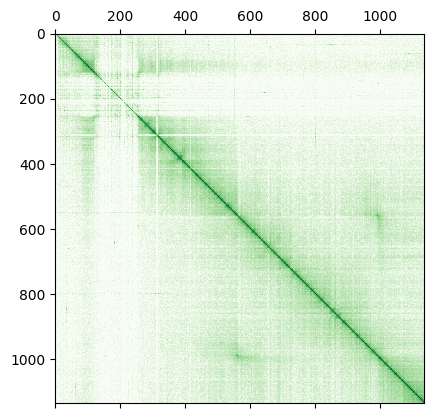

In [21]:
resolution = 50000
chr = '2R'
c = cooler.Cooler(f'data/ZANU/ZANU_clean_4DN.mcool::/resolutions/{resolution}')
mat_balanced = c.matrix(balance=False).fetch(chr)
mat_balanced+=1

chunkFile = ContactMatrixFacet.get_file_descriptor('data/arab_dongX_vs_mopti_2nd_try.hdf5')
ContactMatrixFacet.open_file(chunkFile)
ContactMatrixFacet.load_assembly_from_agp(chunkFile, Path('data/mopti_female_assembly_2.agp'))
scf_desc = chunkFile.scaffold_holder.scaffold_table[1]

#matrix = MatrixVisualise.log_matrix(MatrixVisualise.calculate_diag_means(mat_balanced, scf_desc,scf_desc),addition=0,remove_zeros=False)
matrix = np.log10(mat_balanced)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(matrix, cmap='Greens')

In [22]:
c.matrix(balance=False).fetch('2L').shape[0]

998

In [24]:
resolution = 10000
chr = '2R'
c = cooler.Cooler(f'data/ZANU/ZANU_clean_4DN.mcool::/resolutions/{resolution}')
mat_balanced = c.matrix(balance=False).fetch(chr)
mat_balanced+=1

matrix = np.log10(mat_balanced)

max_value = np.max(matrix)
min_value = np.min(matrix)
positive_class_n = 16 #1536 - 500 - 400 - 350
was_added = set()
for _ in range(positive_class_n):
    i = random.randint(10, matrix.shape[0]-10)
    while i in was_added:
        i = random.randint(10, matrix.shape[0]-10)
    was_added.add(i)
    point = (i, i)
    point_area = matrix[point[1]-10:point[1]+10, point[0]-10:point[0]+10]
    plt.imsave(f'datasets/images_center_10/negative/ZANU_2_{(i+998)*resolution}_{(i+998)*resolution}.png', point_area, cmap='gray', vmax=max_value, vmin=min_value)
    #plt.imshow(np.log10(point_area), cmap='Greens', vmax=max_value, vmin=0)

## Создание тестовых образцов для классификации моделью

In [2]:
chunkFile = ContactMatrixFacet.get_file_descriptor('data/arab_dongX_vs_mopti_2nd_try.hdf5')
ContactMatrixFacet.open_file(chunkFile)
ContactMatrixFacet.load_assembly_from_agp(chunkFile, Path('data/mopti_female_assembly_2.agp'))
resolution = 50000
matrix = MatrixVisualise.get_matrix(chunkFile, 'scaffold_5', resolution, False)
scf_desc = chunkFile.scaffold_holder.scaffold_table[1]

Exception: Unknown length unit

In [7]:
chr = 'X'
resolution = 10000
c = cooler.Cooler(f'data/ARAb_vs_Coluzzii/ARAB_vs_Coluzzii_4DN.mcool::/resolutions/{resolution}')
matrix = c.matrix(balance=False).fetch(chr)

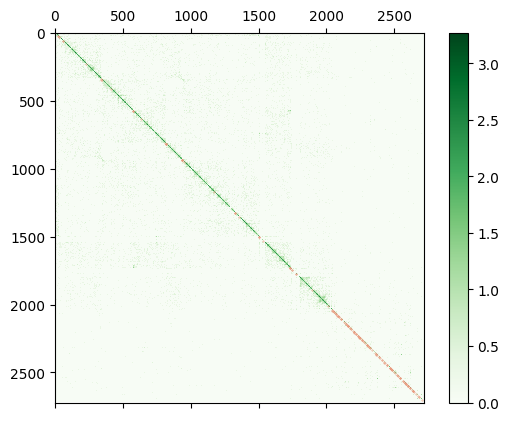

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(matrix+1), cmap='Greens')
fig.colorbar(im)

trans = pd.read_csv('data/ac_detected_rearrangements_ensemble_10.csv')
trans['start_res'] = trans.start // resolution
trans['end_res'] = trans.end // resolution
plt.scatter(trans.start_res, trans.end_res,s=0.1, c='#E9967A')

plt.savefig('ac_trans_center_unbalanced_10k.png', dpi=1000)

In [8]:
src_matrix = np.log10(matrix+1)
max_value = np.nanmax(src_matrix)
min_value = np.nanmin(src_matrix)
for i in range(10, src_matrix.shape[0]-10):
        point = (i, i)
        point_area = src_matrix[point[1]-10:point[1]+10, point[0]-10:point[0]+10]
        plt.imsave(f'datasets/test_images_center_10/unknown/sc5_{i*resolution}_{i*resolution}.png',  point_area, cmap='gray', vmax=max_value, vmin=min_value)